# Predicting users who will make purchase based on web activites

We have web activities of user with timestamp of the activity and as well as the user id's. We will explore the data and try to find features which are helpful in deciding weather the user will purchase or not.

We will import all the required libraires and train a classifier and get prediction results.

In [607]:
import sys
# !{sys.executable} -m pip install seaborn
import pandas as pd
import numpy as np

import os 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

### Works on the data

 + We will load the data,rename the column and transform the date column to datetype.
 + We will group the data using unique value (user_id) and we will one-hot encode the activity by taking sum. For this    we will use pd.get_dummies function.
 + Next step we will split the data to training and testing, and use them to train and evaluate models.
 + We have split the data like train -> 70% and test -> 30%. We have not used the shuffle, which we can use it later in model evaluation.
 + We will remove the user_id value. Make purchase values as 0/1 binary (0 => No purchase, 1 => purchase).
 
 

In [608]:
train_test = pd.read_csv('training.tsv',sep='\t',header=None)

In [609]:

train_test = train_test.rename(index=str, columns={0: "user_id", 1: "date",2:"activity"})
train_test['date'] = pd.to_datetime(pd.Series(train_test['date']), format="%Y/%m/%d")


In [610]:
train_test = pd.get_dummies(train_test, columns=['activity']).groupby(['user_id'], as_index=False).sum()

In [611]:
#First we will split training and testing data 70%/30%
train_df = train_test[:240000]
test_df = train_test[240000:]

In [612]:
#Save the user_id and target vale
train_df_user = train_df['user_id'].values
test_df_user = test_df['user_id'].values


In [613]:
#Rename activity_Purchase to purchase
train_df = train_df.rename(index=str, columns={"activity_Purchase": "purchase"})
test_df = test_df.rename(index=str, columns={"activity_Purchase": "purchase"})

In [614]:
#Changing the purchase value to 0/1

train_df['purchase'] = np.where(train_df.purchase > 0, 1, train_df.purchase)
test_df['purchase'] = np.where(test_df.purchase > 0, 1, test_df.purchase)

In [615]:
# Let us remove user_id from the training set
train_x = train_df.loc[:, 'activity_CustomerSupport':'activity_WebVisit']
test_x = test_df.loc[:, 'activity_CustomerSupport':'activity_WebVisit']

### Once the feature construcrtion is done, we will try to find the correlated features with the target variable. And we will remove highly correlated feature with the target variable.

In [616]:
#Checking correlation of the generated features of the data with the target variable.
correlations = train_x.corr()['purchase'].sort_values()

print('Most Positive Correlations:\n', correlations)


Most Positive Correlations:
 activity_FormSubmit           0.062466
activity_EmailClickthrough    0.074485
activity_EmailOpen            0.080390
activity_WebVisit             0.092075
activity_PageView             0.092240
activity_CustomerSupport      1.000000
purchase                      1.000000
Name: purchase, dtype: float64


## Based on the above results, it seems CustomerSupport is having value of 1.0, so we will remove that as having it will make the model to not perform well.

In [617]:
#The feature activity_CustomerSupport is highly correlated, keeping it in the data will make the model not to work well.

train_x = train_x.drop(['activity_CustomerSupport'],axis=1)
test_x = test_x.drop(['activity_CustomerSupport'],axis=1)

In [618]:
correlations = train_x.corr()['purchase'].sort_values()

print('Most Positive Correlations:\n', correlations)


Most Positive Correlations:
 activity_FormSubmit           0.062466
activity_EmailClickthrough    0.074485
activity_EmailOpen            0.080390
activity_WebVisit             0.092075
activity_PageView             0.092240
purchase                      1.000000
Name: purchase, dtype: float64


In [619]:
training_data_features = list(train_x.columns)

In [621]:
training_data_features.remove('purchase')

#### From above correlation plot we can see that following features are positively correlated with the target variable, 
 + EmailOpen
 + WebVisit
 + PageView
 
#### But we can make any true assumption of the data based on this information alone, we wil find the important features later in this notebook.

# EDA

### We will try to do following exploratry data analysis on the training data of whole data ,

 + Class distribution of the data
 + Features distribution with respect to target variable.


The purchase class in train data is 73267
The non-purchase class in train data is 166733


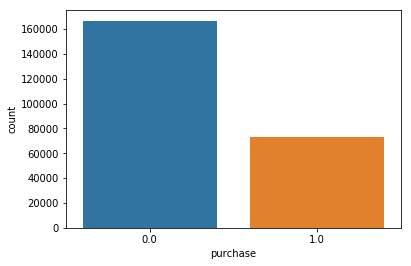

In [557]:
ax = sns.countplot(x='purchase', data=train_x)
print('The purchase class in train data is {}'.format(len(train_x[train_x['purchase']==1])))
print('The non-purchase class in train data is {}'.format(len(train_x[train_x['purchase']==0])))

#### We can observe that there is class imbalance problem, for class imbalance problem we have to use the following evaluation metrics instead of Accuracy alone.

 + Precision
 + Recall
 + F1-Score
 + ROC and AUC 
 + Confuision Matrix

# Feature distribution wrt target (purchase)

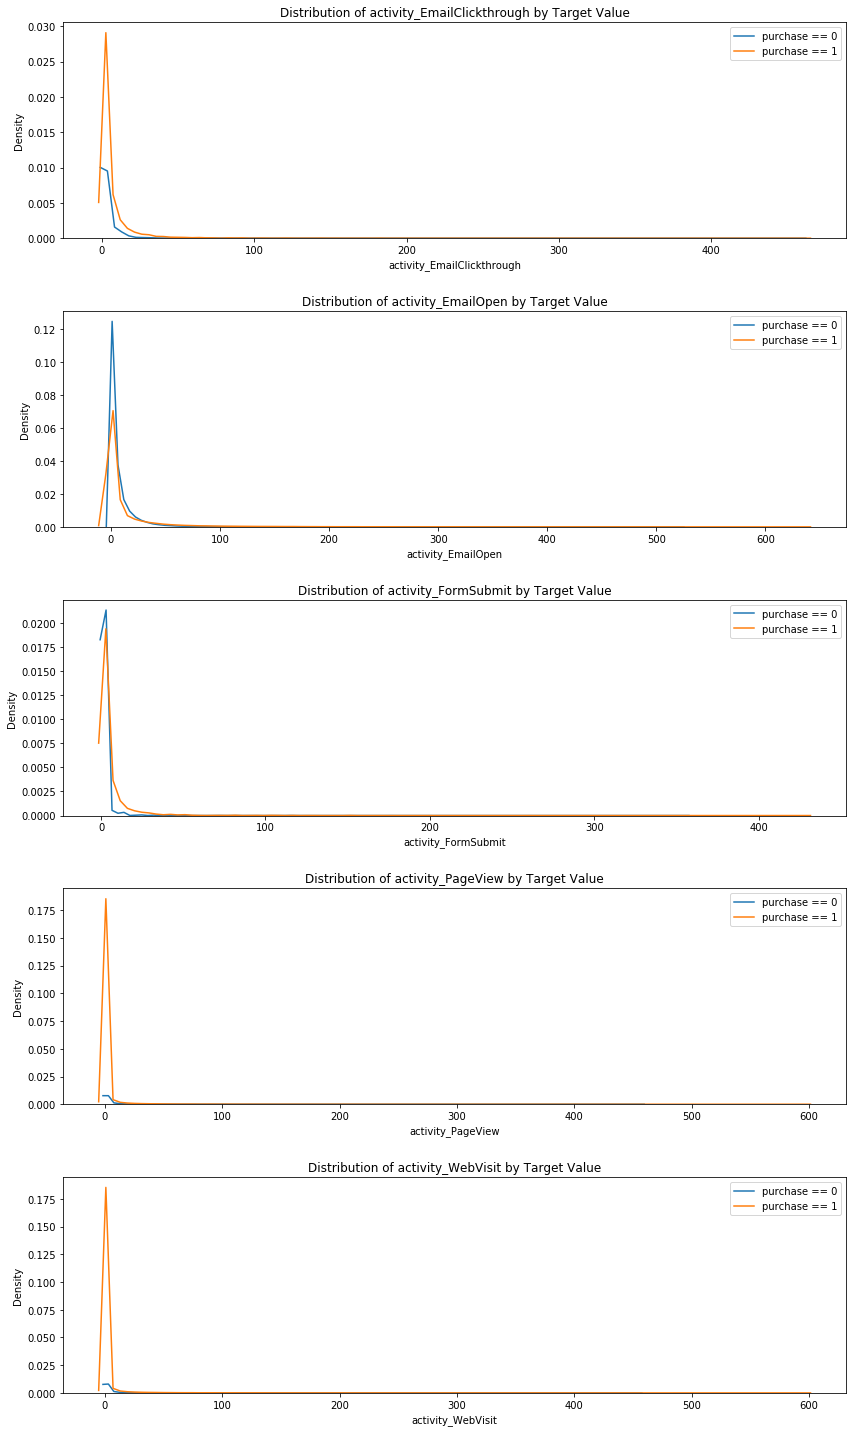

In [558]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['activity_EmailClickthrough', 'activity_EmailOpen', 'activity_FormSubmit', 'activity_PageView','activity_WebVisit']):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_x.loc[train_x['purchase'] == 0, feature], label = 'purchase == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_x.loc[train_x['purchase'] == 1, feature], label = 'purchase == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### From above plots we can see that there is huge skewness in the data. We will try to explore on the features using whiskers plot to see the outlier and skewness.

## Whisker-box plot


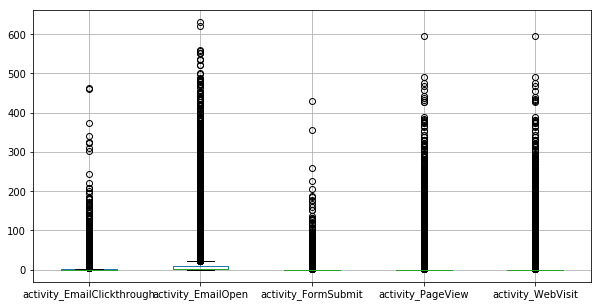

In [664]:
boxplot = train_x.boxplot(column=['activity_EmailClickthrough', 'activity_EmailOpen', 'activity_FormSubmit', 'activity_PageView','activity_WebVisit'],figsize= (10,5))

### From the above plot we can see that all the features are extremly skeewed and rightly-skewed. this is due to the data is not scaled properly, we will try to solve this problem later before fitting the model on data

In [559]:
#Before that we will remove the target from training data
train_y = train_x['purchase']
test_y = test_x['purchase']

train_x = train_x.drop(['purchase'],axis=1)
test_x = test_x.drop(['purchase'],axis=1)

In [598]:
#Normalize the dataset for skewness

from sklearn.preprocessing import MinMaxScaler
train = train_x
test = test_x

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
train_x_scaled = scaler.transform(train)
test_x_scaled = scaler.transform(test)

## Baseline Model - Logistic Regression (L2 - Regularized)

In [561]:
#We will fit a logistic Regression model and test it on test data

from sklearn.linear_model import LogisticRegression



logisticRegr = LogisticRegression(C=0.0001,penalty='l2',class_weight='balanced')


logisticRegr.fit(train_x_scaled, train_y)

predictions_lr = logisticRegr.predict(test_x_scaled)

print()
print("The probability values of the test data of training")
print(logisticRegr.predict_proba(test_x_scaled)[:,1])

score_lr = logisticRegr.score(test_x_scaled, test_y)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(score_lr))




The probability values of the test data of training
[0.49988451 0.50007915 0.50057092 ... 0.49986723 0.50004841 0.4999101 ]
Accuracy of logistic regression classifier on test set: 0.60


In [562]:
#We will get the confusion matrix

import matplotlib.pyplot as plt
from sklearn import metrics
cm = metrics.confusion_matrix(test_y, predictions_lr)
print(cm)

[[55382 15462]
 [24916  5808]]


In [563]:
from sklearn.metrics import classification_report
print(classification_report(test_y, predictions_lr))

             precision    recall  f1-score   support

        0.0       0.69      0.78      0.73     70844
        1.0       0.27      0.19      0.22     30724

avg / total       0.56      0.60      0.58    101568



In [564]:
# we will do the cross validation and compute the mean F1_weighted score

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'f1_weighted'
results = model_selection.cross_val_score(modelCV, train_x_scaled, train_y, cv=kfold, scoring=scoring)
print("10-fold cross validation average F-1 Score is: %.3f" % (results.mean()))


10-fold cross validation average F-1 Score is: 0.586


## Baseline Results

We used L2-Regularized logistic regression model with regularization parameter of 0.0001. We accheived an accuracy of 60%. But since we have class imbalance problem we have F1 as well as ROC (Later). The F1-Score is 0.58, which seems to be descent. So we have baseline F1 as 0.58

## Improved model - RandomForest

#### First we will try to fit a base randomForest model, once it is done we will try to fine tune the parameter of model

In [566]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
base_random_forest = RandomForestClassifier(random_state = 42)

In [567]:

base_random_forest.fit(train_x_scaled, train_y)

# Make predictions on the test data
predictions = base_random_forest.predict_proba(test_x_scaled)[:, 1]

In [666]:
score = base_random_forest.score(test_x_scaled, test_y)
print("Accuracy of baseline model {}.".format(score))

Accuracy of baseline model 0.8969065059861374.


In [669]:

prediction_label_base_rf = [1 if i>=0.5 else 0 for i in predictions]
import matplotlib.pyplot as plt
from sklearn import metrics
cm = metrics.confusion_matrix(test_y, prediction_label_base_rf)
print(cm)

[[68893  1951]
 [ 8516 22208]]


In [572]:

print(classification_report(test_y, prediction_label_base_rf))


             precision    recall  f1-score   support

        0.0       0.89      0.97      0.93     70844
        1.0       0.92      0.72      0.81     30724

avg / total       0.90      0.90      0.89    101568



## Base RandomForest Results

 + We have used basic randomforest classifier to classify the data. 
 + We achieved a good F1-Score of 0.89 and accuracy as 89% (which we wont consider). 
 + The model gives a good precion and recall than baseline logistic regression. 
 + From the confusion matrix we can see tha, true prediction of purchased class by the classifier is increased
 

## Fine tune the randomforest classifier
 + We will perform random search and find best paramneter for the random forest by checking the F1 score.

In [573]:
#First let us see the current parameters of the randomForest
from pprint import pprint
print('Parameters currently in use:\n')
pprint(base_random_forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [574]:
#Let us perform gridsearch for all the parameters
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node

min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50]}


In [576]:
# Use the random search to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,scoring='f1', param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_x_scaled, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=32, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False 
[CV] n_estimators=32, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False 
[CV] n_estimators=32, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=False 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   1.7s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   1.6s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV

[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=   6.3s


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.2s


[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=41, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=12, bootstrap=True, total=   4.8s
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=41, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=12, bootstrap=True, total=   4.6s
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   2.1s
[CV] n_estimators=32, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   2.2s
[CV] n_estimators=32, min_samples_split=5, m

[CV] n_estimators=45, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True 
[CV] n_estimators=45, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=14, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=18, bootstrap=False, total=   2.3s
[CV] n_estimators=23, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True 
[CV]  n_estimators=23, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True, total=   2.9s
[CV] n_estimators=23, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True 
[CV]  n_estimators=45, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=True, total=   6.0s
[CV] n_estimators=23, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True 
[CV]  n_estimators=45, min_samples_split=5, min_samples_le

[CV] n_estimators=41, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False 
[CV]  n_estimators=27, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=16, bootstrap=True, total=   3.3s
[CV] n_estimators=41, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False 
[CV]  n_estimators=27, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=16, bootstrap=True, total=   3.3s
[CV] n_estimators=41, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False 
[CV]  n_estimators=27, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=16, bootstrap=True, total=   3.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=41, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, total=   4.9s
[CV] n_estimators=50, min_samples_split=

[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False, total=   1.5s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=False, total=   7.0s
[CV] n_estimators=14, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False, total=   1.4s
[CV] n_estimators=14, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=False, total=   7.3s
[CV] n_estimators=14, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=14, min_samples_s

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min


[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=41, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   5.8s
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=41, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   5.8s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=False 
[CV]  n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   2.0s
[CV]  n_estimators=41, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   5.6s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=False 
[CV] n_estimators=50, min_samples_sp

[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True 
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, total=   5.6s
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=False 
[CV]  n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=False, total=   2.6s
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=False 
[CV]  n_estimators=18, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=False, total=   2.5s
[CV] n_estimators=41, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=13, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_sample

[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, total=   5.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, total=   5.4s
[CV] n_estimators=23, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=True, total=   4.9s
[CV] n_estimators=23, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=23, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   2.8s
[CV] n_estimators=23, min_samples_split=5

[CV]  n_estimators=27, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=True, total=   5.0s
[CV] n_estimators=27, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=32, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False, total=   7.0s
[CV] n_estimators=27, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=27, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=True, total=   5.0s
[CV] n_estimators=27, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=27, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=True, total=   5.4s
[CV] n_estimators=45, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=27, min_samples_spli

[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True 
[CV]  n_estimators=45, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   6.4s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True 
[CV]  n_estimators=45, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   6.1s
[CV] n_estimators=27, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, total=   6.1s
[CV] n_estimators=27, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=27, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   3.4s
[CV] n_estimators=27, min_samples_split=5,

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 20, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=2)

In [577]:
# The best parmeters of the randomforest classifier
print(rf_random.best_params_)

{'n_estimators': 32, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [578]:
from sklearn.metrics import f1_score

def evaluate(model, test_features, y_true):
    y_pred = model.predict(test_features)
    
    #Here, we will use F1 as evaluation metric of the model
    
    f_score = float(f1_score(y_true, y_pred, average='weighted'))
    
    errors = abs(y_pred - y_true)
   
    
    accuracy = np.mean(y_pred == y_true)*100
    
    
    
    print('Model Performance')
    print('Average F1 score: {} .'.format(f_score))
    print('Average Error: {:0.4f} .'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return f_score



In [579]:


base_model = RandomForestClassifier(random_state = 42)
base_model.fit(train_x_scaled, train_y)
base_f1 = evaluate(base_model, test_x_scaled, test_y)


best_random = rf_random.best_estimator_
random_f1 = evaluate(best_random, test_x_scaled, test_y)

print('Improvement of F1 Score is  {:0.4f}.'.format( (random_f1 - base_f1) / base_f1))


Model Performance
Average F1 score: 0.8926907314837218 .
Average Error: 0.1031 .
Accuracy = 89.69%.
Model Performance
Average F1 score: 0.8978998856678834 .
Average Error: 0.0977 .
Accuracy = 90.23%.
Improvement of F1 Score is  0.0058.


#### F1, precision, recall of fine-tuned randomForest

In [580]:
#Let us find the precision, recall anbd F1 score of the best random forest model
pred_y_best_rf = best_random.predict(test_x_scaled)
print(classification_report(test_y, pred_y_best_rf))

             precision    recall  f1-score   support

        0.0       0.89      0.98      0.93     70844
        1.0       0.95      0.71      0.82     30724

avg / total       0.91      0.90      0.90    101568



#### Confusion Matrix of the fine-tuned random forest

In [581]:

import matplotlib.pyplot as plt
from sklearn import metrics
cm = metrics.confusion_matrix(test_y, pred_y_best_rf)
print(cm)

[[69709  1135]
 [ 8784 21940]]


## Result from random search

 + We got best parameters and we used on the test data, we got an incresed F1-Score of 0.9 from 0.892.

# RoC and AuC of all model

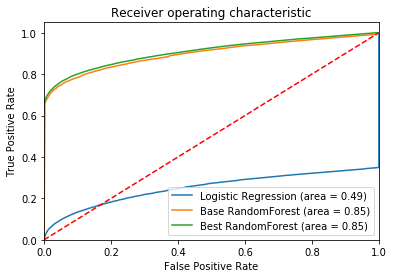

In [583]:
#Let us plot ROC and AUC of the models 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#FPR and TPR from logistic regression
logit_roc_auc = roc_auc_score(test_y, logisticRegr.predict(test_x_scaled))
fpr_logit, tpr_logit, thresholds_logit = roc_curve(test_y, logisticRegr.predict_proba(test_x_scaled)[:,1])

#FPR and TPR from base randomForestClassifier
base_random_roc_auc = roc_auc_score(test_y, base_random_forest.predict(test_x_scaled))
fpr_base_rf, tpr_base_rf, thresholds_base_rf = roc_curve(test_y, base_random_forest.predict_proba(test_x_scaled)[:,1])

best_random_roc_auc = roc_auc_score(test_y, best_random.predict(test_x_scaled))
fpr_best_rf, tpr_best_rf, thresholds_best_rf = roc_curve(test_y, best_random.predict_proba(test_x_scaled)[:,1])

plt.figure()

plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_base_rf, tpr_base_rf, label='Base RandomForest (area = %0.2f)' % base_random_roc_auc)
plt.plot(fpr_best_rf, tpr_best_rf, label='Best RandomForest (area = %0.2f)' % best_random_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### From the above plot the fine tuned randomforest gives us better area under curve of 0.85. Compared to baseline model we have built powerful fine tuned random forest.

### Important Features/categories 

The important categories are plotted below from RandomForest.
 
 + EmailOpen
 + FormSubmit
 + EmailClickThrough

The above three categories are important in prediciting users who will purchase.

In [584]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized (0 - 1)'); plt.title('Feature Importances')
    plt.show()
    
    return df

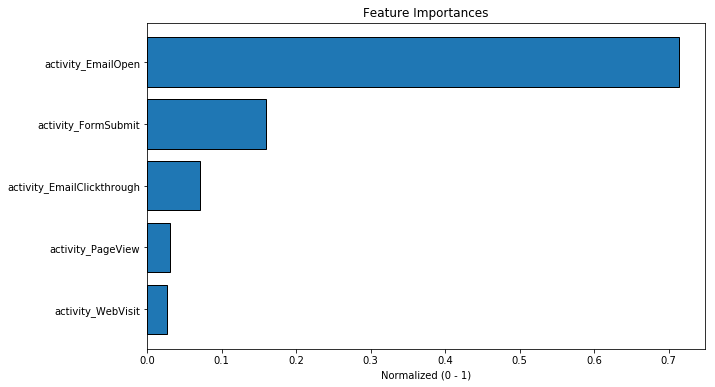

In [585]:
# Extract feature importances
feature_importance_values = best_random.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)

So from randomforest model we can see that the following features/categories are important in deciding the user will purchase or not,
 + EmailOpen
 + FormSubmit
 + WebVisit
 

We have built a model to predict the users who will make a purchase, we evaluated the model based on following metrics,
 + Precision
 + Recall
 + F1-Score
 + ROC and AUC
 + Confusion Matrix

We will test the model on the unseen data and record probability of purchase for each user.

We wil load the test data and generate features, drop hihgly correlated feature as we did for the training data and check the features of test data with the train data we used to build the model.

In [622]:
test_data = pd.read_csv('test.tsv',sep='\t',header=None)

In [623]:
test_data =  test_data.rename(index=str, columns={0: "user_id", 1: "date",2:"activity"})
test_data['date'] = pd.to_datetime(pd.Series(test_data['date']), format="%Y/%m/%d")


In [624]:
test_data = pd.get_dummies(test_data, columns=['activity']).groupby(['user_id'], as_index=False).sum()

In [625]:
test_data_user = test_data['user_id'].values

In [626]:
test_data = test_data.drop(['user_id'],axis=1)

In [627]:
#Debugging the features we got from the test data to the training data

test_data_features = list(test_data.columns)
assert test_data_features == training_data_features, "Features are not same"

In [628]:
test_data.head(5)

,activity_EmailClickthrough,activity_EmailOpen,activity_FormSubmit,activity_PageView,activity_WebVisit
0,0,5,0,0,0
1,1,1,0,0,0
2,0,3,0,0,0
3,0,4,0,0,0
4,0,3,0,0,0


In [629]:
#Apply MinMax of the training data on the test data

test_data_scaled = scaler.transform(test_data)


In [638]:
#Get prediction probability of the test data, from best_randomforest classifier

test_predicted_probability = best_random.predict_proba(test_data_scaled)[:,1]
test_predicted_class =best_random.predict(test_data_scaled)
print(test_predicted_probability)
print(test_predicted_class)
print(test_data_user)

[0.09359257 0.10080072 0.08460935 ... 0.06492925 0.06492925 0.09359257]
[0. 0. 0. ... 0. 0. 0.]
['0000ecf58c94668' '000132f21724ee2' '0001b315b991cf0' ...
 'fffed482b52afd8' 'ffffa4cc0190881' 'ffffecdd8dc6174']


In [646]:
test_output_list = list(zip(test_data_user,test_predicted_probability))

In [647]:
test_op = pd.DataFrame(test_output_list,columns=['user_id','purchase_prob'])

In [661]:
test_op.head(5)

,user_id,purchase_prob
0,0000ecf58c94668,0.093593
1,000132f21724ee2,0.100801
2,0001b315b991cf0,0.084609
3,000269150971d08,0.087454
4,000297ba4fa5026,0.084609


In [652]:
test_op_sorted = test_op.sort_values('purchase_prob',ascending = False,ind)

In [654]:
top_user = test_op_sorted.head(1000)

### The top 1000 users who most likely to convert are written on top_1000_user.csv files along with the probability.

In [660]:
top_user.to_csv('top_1000_user.csv', sep='\t', encoding='utf-8',index=False)